In [1]:
from datasets.idda import IDDADataset
from datasets.gtaV import GTAVDataset
from datasets.idda import showIDDAsample
from models.deeplabv3 import deeplabv3_mobilenetv2
from torch.utils.data import DataLoader
import datasets.ss_transforms as sstr
import json

In [2]:
from steps import Args
arg=Args(25,8,lr={'type':'polynomial','from':0.1,'to':0.05,'steps':45,'exponent':0.9})
arg=Args(25,8,lr={'type':'cyclical','min':0.05,'max':0.1,'period':46})

for i in range(70):
    print(arg.getLr(i))

0.1
0.09782608695652174
0.09565217391304348
0.09347826086956522
0.09130434782608696
0.08913043478260871
0.08695652173913043
0.08478260869565218
0.08260869565217392
0.08043478260869566
0.0782608695652174
0.07608695652173914
0.07391304347826087
0.07173913043478261
0.06956521739130435
0.06739130434782609
0.06521739130434784
0.06304347826086956
0.06086956521739131
0.058695652173913045
0.05652173913043479
0.05434782608695652
0.052173913043478265
0.05
0.052173913043478265
0.05434782608695652
0.05652173913043479
0.058695652173913045
0.06086956521739131
0.06304347826086956
0.06521739130434784
0.06739130434782609
0.06956521739130435
0.07173913043478261
0.07391304347826087
0.07608695652173914
0.0782608695652174
0.08043478260869566
0.08260869565217392
0.08478260869565218
0.08695652173913043
0.08913043478260871
0.09130434782608696
0.09347826086956522
0.09565217391304348
0.09782608695652174
0.1
0.09782608695652174
0.09565217391304348
0.09347826086956522
0.09130434782608696
0.08913043478260871
0.086

In [2]:
import numpy as np
p=0.5
np.random.binomial(1,p)

1

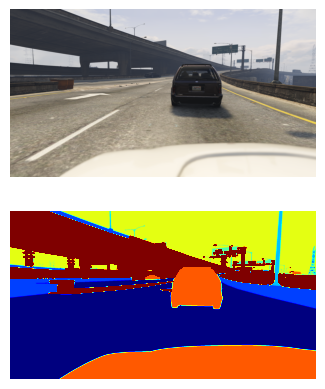

In [2]:
#first you need to apply the other map.
gtaVtest=GTAVDataset(root='data/GTA5',fileName='train.txt',transform=sstr.ToTensor())
showIDDAsample(gtaVtest[20])

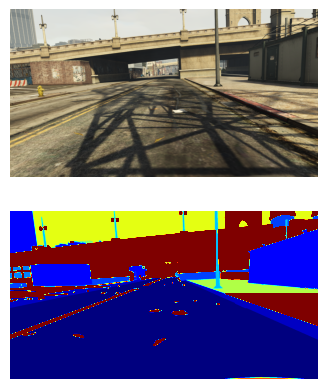

In [4]:
showIDDAsample(gtaVtest[12])

In [2]:
from steps import Args
print("The format is (from_round,to_round,lr,m)")

# First rounds with initial value. Then at the given rounds (not counted from previous, but from start) goes to given values
argsTest=Args(30,2,change_lr_m=[(4,10),(22,5)],change_time='at_given_rounds',change_type='new_val')
print("Test cycle given rounds:", argsTest.progressive_lr_m)
argsTest=Args(30,2,change_lr_m=[(4,10),(22,5)],change_time='at_given_rounds',change_type='fact_drop')
print("Test change given rounds:", argsTest.progressive_lr_m)
#same as above, but change number is the number of rounds after the last change
argsTest=Args(30,2,change_lr_m=[(4,10),(22,5)],change_time='after_given_rounds',change_type='new_val')
print("Test cycle after given rounds:", argsTest.progressive_lr_m)
# First rounds with initial value. Then after 4 rounds goes to 2, after 2 to 5, then againb after 4 to 2,...
argsTest=Args(30,2,change_lr_m=[(4,10),(2,5)],change_time='cyclical',change_type='new_val')
print("Test cycle (lr):", argsTest.progressive_lr_m)
argsTest=Args(30,2,change_lr_m=[(4,10),(2,5)],change_time='cyclical',change_type='new_val')
print("Test cycle (lr+m):", argsTest.progressive_lr_m)
# Drop factor each 4 rounds
argsTest=Args(30,2,change_lr_m=[(4,10)],change_time='cyclical',change_type='fact_drop')
print("Test constant factor drop:",argsTest.progressive_lr_m)
argsTest=Args(30,2,change_lr_m=[(4,10),(2,5)],change_time='cyclical',change_type='abs_drop')
print("Test constant minus drop [CAN GO NEGATIVE]:", argsTest.progressive_lr_m)

The format is (from_round,to_round,lr,m)
Test cycle given rounds: [(0, 4, 0.05, 0.9), (4, 22, 10, 0.9), (22, 30, 5, 0.9)]
Test change given rounds: [(0, 4, 0.05, 0.9), (4, 22, 0.005, 0.9), (22, 30, 0.001, 0.9)]
Test cycle after given rounds: [(0, 4, 0.05, 0.9), (4, 26, 10, 0.9), (26, 30, 5, 0.9)]
Test cycle (lr): [(0, 4, 0.05, 0.9), (4, 6, 10, 0.9), (6, 10, 5, 0.9), (10, 12, 10, 0.9), (12, 16, 5, 0.9), (16, 18, 10, 0.9), (18, 22, 5, 0.9), (22, 24, 10, 0.9), (24, 28, 5, 0.9), (28, 30, 10, 0.9)]
Test cycle (lr+m): [(0, 4, 0.05, 0.9), (4, 6, 10, 0.9), (6, 10, 5, 0.9), (10, 12, 10, 0.9), (12, 16, 5, 0.9), (16, 18, 10, 0.9), (18, 22, 5, 0.9), (22, 24, 10, 0.9), (24, 28, 5, 0.9), (28, 30, 10, 0.9)]
Test constant factor drop: [(0, 4, 0.05, 0.9), (4, 8, 0.005, 0.9), (8, 12, 0.0005, 0.9), (12, 16, 5e-05, 0.9), (16, 20, 5e-06, 0.9), (20, 24, 5.000000000000001e-07, 0.9), (24, 28, 5.000000000000001e-08, 0.9), (28, 30, 5.000000000000001e-09, 0.9)]
Test constant minus drop [CAN GO NEGATIVE]: [(0, 4,

In [4]:
train_transform=sstr.Compose([sstr.RandomCompose([sstr.Resize((2,3))],0.2),sstr.ToTensor()])
train_transform=sstr.Compose([sstr.RandomCrop(),sstr.ToTensor()])
train_transform=sstr.Compose([sstr.ColorJitter(0.5,0,0,0.3),sstr.ToTensor()])
train_transform=sstr.Compose([sstr.ToTensor(),sstr.OneOf([sstr.EnhanceCloud(),sstr.EnhanceSunset()])])
#train_transform=sstr.Compose([sstr.ToTensor()])
#sstr.RandomResizedCrop((512,928),scale=(0.5,2))


In [5]:
iddaTrain=IDDADataset('data/idda',fileName='train.txt',transform=train_transform)
print(f'Training set size: {iddaTrain.__len__()}')
iddaTestSame=IDDADataset('data/idda',fileName='test_same_dom.txt')
print(f'Test set size for same domain: {iddaTestSame.__len__()}')
iddaTestDiff=IDDADataset('data/idda',fileName='test_diff_dom.txt')
print(f'Test set size for diff domain: {iddaTestDiff.__len__()}')

Training set size: 600
Test set size for same domain: 120
Test set size for diff domain: 120


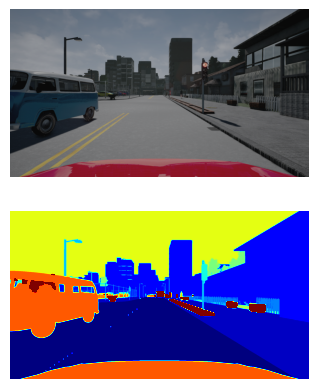

In [8]:
#showing a random sample
showIDDAsample(iddaTrain[14])

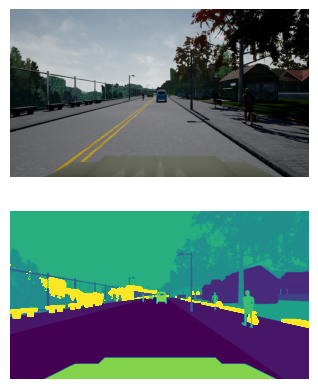

In [5]:
train_transform=sstr.Compose([sstr.ToTensor()])
iddaTrain=IDDADataset('data/idda',fileName='train.txt',transform=train_transform)
showIDDAsample(iddaTrain[140])

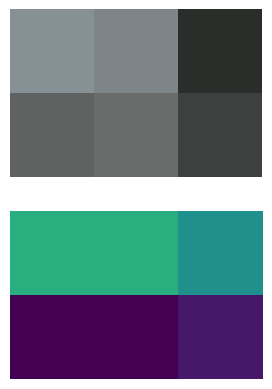

In [6]:
train_transform=sstr.Compose([sstr.Resize((2,3)),sstr.ToTensor()])
iddaTrain=IDDADataset('data/idda',fileName='train.txt',transform=train_transform)
showIDDAsample(iddaTrain[140])

In [9]:
from client import Client
from server import Server
from models.deeplabv3 import deeplabv3_mobilenetv2
def createCentralizedServer(model,metrics,train_transform,test_transform,num_epochs,batch_size,root='data/idda'):
    iddaTrain=IDDADataset(root,fileName='train.txt',transform=train_transform,client_name='Centralized server')
    iddaTestSame=IDDADataset(root,fileName='test_same_dom.txt',transform=test_transform,client_name='IDDA same domain')
    iddaTestDiff=IDDADataset(root,fileName='test_diff_dom.txt',transform=test_transform,client_name='IDDA different domain')
    train_clients=[Client(dataset=iddaTrain,model=model,num_epochs=num_epochs,batch_size=batch_size)]
    test_clients=[Client(dataset=iddaTestDiff,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size),Client(dataset=iddaTestSame,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size)]
    return Server(train_clients=train_clients,test_clients=test_clients,model=model,metrics=metrics,num_rounds=1,clients_per_round=1)

In [10]:
#Parameters that MUST be changed
initialModel=deeplabv3_mobilenetv2(num_classes=16)
metrics='provaAcaso'
test_tr=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
train_tr=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
central=createCentralizedServer(initialModel,metrics,train_tr,test_tr,41,24)

TypeError: Client.__init__() got an unexpected keyword argument 'num_epochs'

In [11]:
import json
def createServerStep2(model,metrics,train_transform,test_transform,num_epochs,batch_size,num_rounds,clients_per_round,root='data/idda'):
    f=open(root+'/train.json')
    clients=json.load(f)
    train_clients=[]
    for key in clients:
        train_clients.append(Client(dataset=IDDADataset(root,list_samples=clients[key],transform=train_transform,client_name=key),model=model,num_epochs=num_epochs,batch_size=batch_size))
    
    #Not clear which test set to use
    iddaTestSame=IDDADataset(root,fileName='test_same_dom.txt',transform=test_transform,client_name='IDDA same domain')
    iddaTestDiff=IDDADataset(root,fileName='test_diff_dom.txt',transform=test_transform,client_name='IDDA different domain')
    test_clients=[Client(dataset=iddaTestDiff,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size),Client(dataset=iddaTestSame,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size)]
    return Server(train_clients=train_clients,test_clients=test_clients,model=model,metrics=metrics,num_rounds=num_rounds,clients_per_round=clients_per_round)

In [12]:
server2=createServerStep2(model=initialModel,metrics=metrics,train_transform=train_tr,test_transform=test_tr,num_epochs=23,num_rounds=10,batch_size=10,clients_per_round=4)

TypeError: Client.__init__() got an unexpected keyword argument 'num_epochs'